# **Are older players doing better more recently?**

Since the ascendancy and sustained success of Federer, Nadal, and Djokovic, it's seemed like the top players in tennis have skewed older. Let's try to evaluate this empirically. We'll look at this from a few perspectives:

- Elo ratings for all players by age, by year of first match. 
- Average Elo rating by age and year. 
- Average ATP ranking by age and year. 
- Average age for players that hit the top 10 by year. 

First, let's mount the google drive, import libraries we need, and connect to our SQL database. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter 

In [ ]:
connection = sqlite3.connect('/content/drive/My Drive/ATP Tennis/Database/ATP_Tennis.db')
c = connection.cursor()

So let's start with all Elo ratings by age. 

We limit our resutls to players that were age 23 or younger in our data. This ensures we capture players early enough in their careers. Most players turn pro around age 22. First, we pull the relevant data from the database. Then we create a dataset that has an observation for the winner and loser of each match. We drop missing ages and create a table with min age and year for each player.

In [ ]:
c.execute('''
SELECT  a.MatchEloID, a.year, a.winner_id, a.loser_id, a.winner_age, a.loser_age, 
        a.winner_rank, a.loser_rank, a.PreMatchElo_Winner, a.PreMatchElo_Loser, 
        a.winner_name, a.loser_name
FROM ATP_MATCHES as a 
INNER JOIN ATP_PLAYERS as b ON a.winner_id=b.player
INNER JOIN ATP_PLAYERS as c ON a.loser_id=c.player
''')
matches = pd.DataFrame(c.fetchall(),columns=[c.description[i][0] for i in range(len(c.description))])

winners = matches[["MatchEloID","year","winner_id","winner_name","winner_age","winner_rank","PreMatchElo_Winner"]]
winners["win"] = 1
winners = winners.rename(columns={"winner_id": "id", "winner_name": "name", "winner_age": "age", "winner_rank": "rank", "PreMatchElo_Winner": "PreMatchElo"})

losers = matches[["MatchEloID","year","loser_id","loser_name","loser_age","loser_rank","PreMatchElo_Loser"]]
losers["win"] = 0
losers = losers.rename(columns={"loser_id": "id", "loser_name": "name", "loser_age": "age", "loser_rank": "rank", "PreMatchElo_Loser": "PreMatchElo"})

all = pd.concat([winners,losers]).sort_values(by=["MatchEloID","win"]).reset_index()
all = all[all["age"].notnull()]

mins = pd.DataFrame(all.groupby('id')[['year','age']].agg('min'))
mins = mins[mins["age"]<=23]
mins["start_half_decade"] = np.floor((mins["year"]-1990)/5)*5 + 1990
mins['id'] = mins.index

Next, we plot Elo ratings by age for all players, highlighting the best players. This is to get a sense of typical Elo trajectories.

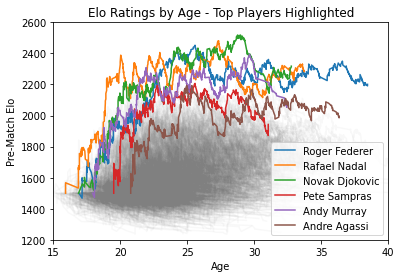

In [ ]:
for id in list(mins['id']):
  player = all[all["id"]==id].sort_values(by="MatchEloID").set_index("age")
  plt.plot(player["PreMatchElo"],c="grey",alpha=0.05)
for name in ["Roger Federer","Rafael Nadal","Novak Djokovic","Pete Sampras","Andy Murray","Andre Agassi"]:
  player = all[all["name"]==name].sort_values(by="MatchEloID").set_index("age")
  plt.plot(player["PreMatchElo"],label=name)

plt.xlim(15,40)
plt.ylim(1200,2600)
plt.legend(loc="lower right")
plt.title("Elo Ratings by Age - Top Players Highlighted")
plt.xlabel("Age")
plt.ylabel("Pre-Match Elo")
plt.show()

Now we plot Elo ratings by age but broken out by the half decade in which each player started their career. The comparison of these charts is a bit tricky. When trying to assess if older players are doing better now more than ever, we need to look at the clustering of Elo ratings rougly above age 30 for each half decade. We should also look at how many players have careers that last into their 30's. These charts are hard to interpert overall, so the conclusions we can draw are not precise. We see that there are pretty similar numbers of such players for all half decades and that these players have pretty simlar ratings. That is, there is a similar number of players that play into their 30's for players that started playing between 1990-1994 as well as those that started playing between 2005-2009. Further, these players' ratings dont look dramatically different.  A difficulty in this analysis is that players starting their careers more recently are younger. But in all charts, the field thins pretty dramatically after age 30.  

What's really most notable in these charts is how much better than their peers are Federer, Nadal, and Djokovic. 

But we'll need some summary statistics to understand what's going on better. 




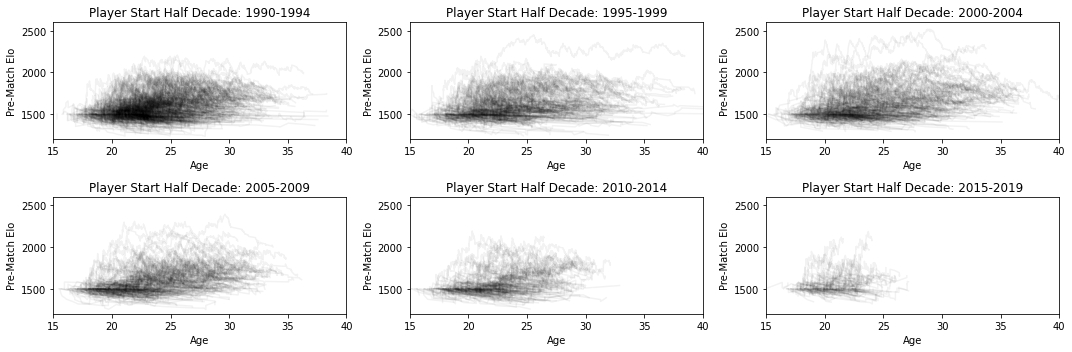

In [ ]:
def p(y,loc):
  plt.subplot(2, 3, loc)
  for id in list(mins[mins["start_half_decade"]==y]['id']):
    player = all[all["id"]==id].sort_values(by="MatchEloID").set_index("age")
    plt.plot(player["PreMatchElo"],c="black",alpha=0.05)
  plt.xlim(15,40)
  plt.ylim(1200,2600)
  plt.title("Player Start Half Decade: "+str(int(y))+"-"+str(int(y+4)))
  plt.xlabel("Age")
  plt.ylabel("Pre-Match Elo")
  plt.xticks(rotation=0)
  
plt.figure(figsize=(15,5))
p(1990.0,loc=1)
p(1995.0,loc=2)
p(2000.0,loc=3)
p(2005.0,loc=4)
p(2010.0,loc=5)
p(2015.0,loc=6)
plt.tight_layout()
plt.show()

Let's take another view. Let's look at average Elo ratings by age and by year. We'll also look at a similar comparision for ATP ranking. We see here that indeed 30+ players have been doing best in the 2010's. This trend remains if we exlude the big 4. But recently younger players have been doing better. Note that we exclude players younger than 20 since they are often much lower ranked / rated. 

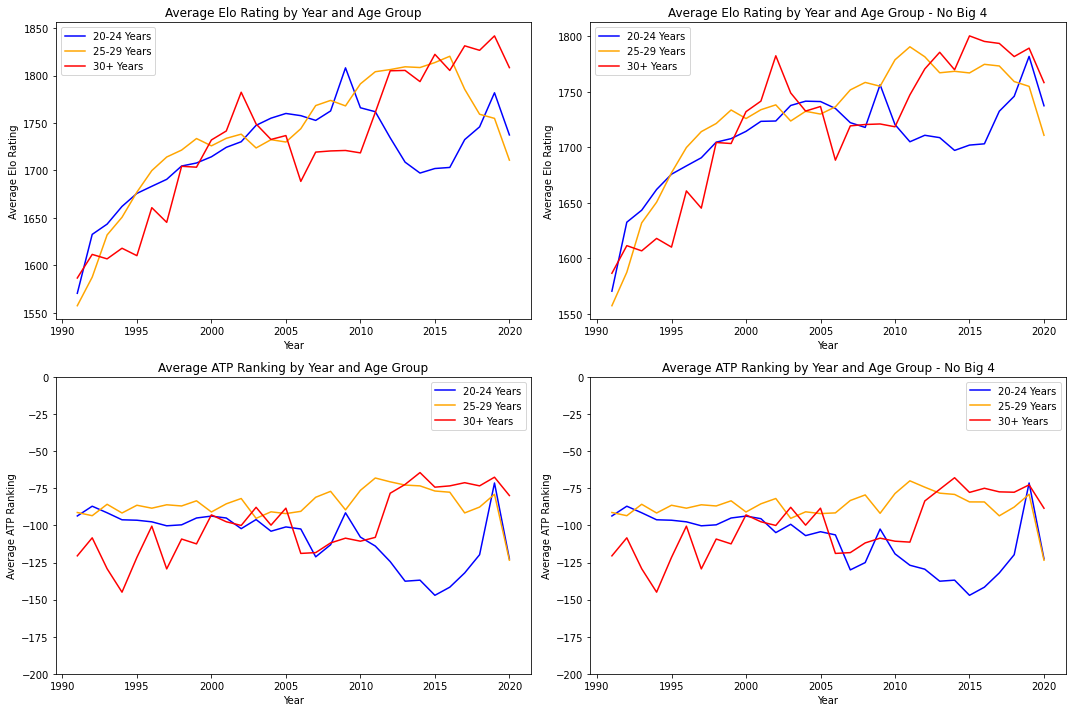

In [ ]:
all["age_group"] = np.floor((all["age"]-15)/5)*5 + 15
all["age_group"] = np.where(all["age_group"]>=30,30,all["age_group"])

limited = all[(all["name"] != "Roger Federer") & 
              (all["name"] != "Rafael Nadal") & 
              (all["name"] != "Novak Djokovic") & 
              (all["name"] != "Andy Murray")]

def p(dta,lim,var,type,loc):
  mean = pd.DataFrame(dta.groupby(['year','age_group'])[[var]].agg('mean'))

  mean.reset_index(inplace=True)  
  if var=="rank":
    mean["rank"] = -mean["rank"]
  mean = mean.pivot(index='year',columns='age_group')[[var]]
  mean.reset_index(inplace=True) 
  mean.columns = mean.columns.get_level_values(1)

  plt.subplot(2, 2, loc)
  #plt.plot(mean[""],mean[15.0],label="15-19 Years",c="lightblue")
  plt.plot(mean[""],mean[20.0],label="20-24 Years",c="blue")
  plt.plot(mean[""],mean[25.0],label="25-29 Years",c="orange")
  plt.plot(mean[""],mean[30.0],label="30+ Years",c="red")
  plt.legend()
  
  if lim=="lim":
    plt.title("Average "+type+" by Year and Age Group - No Big 4")
  else:
    plt.title("Average "+type+" by Year and Age Group")
  plt.xlabel("Year")
  plt.ylabel("Average "+type)
  if var=="rank":
    plt.ylim(-200,0)

plt.figure(figsize=(15,10))
p(all,"all","PreMatchElo","Elo Rating",loc=1)
p(limited,"lim","PreMatchElo","Elo Rating",loc=2)
p(all,"all","rank","ATP Ranking",loc=3)
p(limited,"lim","rank","ATP Ranking",loc=4)
plt.tight_layout()
plt.show()


Finally, we'll look at the average age for players that hit the top 10 by year. We see that the average age of top 10 players did jump in the 2010's and that this has persisted. However, we see that when we remove the big 4, the trend exists in the early 2010's but then drops away in more recent years. 

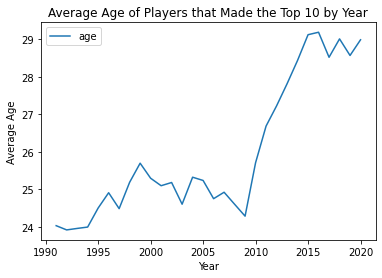

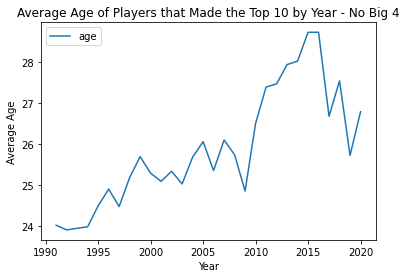

In [ ]:
pd.DataFrame(all[all["rank"]<=10].groupby(['year'])[["age"]].agg('mean')).plot()
plt.title("Average Age of Players that Made the Top 10 by Year")
plt.xlabel("Year")
plt.ylabel("Average Age")
plt.show()

pd.DataFrame(limited[limited["rank"]<=10].groupby(['year'])[["age"]].agg('mean')).plot()
plt.title("Average Age of Players that Made the Top 10 by Year - No Big 4")
plt.xlabel("Year")
plt.ylabel("Average Age")
plt.show()

All told, there is convincing evidence that in the early 2010's there was a dearth of high performing younger players. The top 10 was filled with older players and older players has higher Elo ratings and ATP rankings on average. This trend has been falling away in more recent years. 